## Import libraries

In [1]:
import pandas as pd
import numpy as np

# Read data

In [2]:
data = pd.read_csv('/Users/shree/Downloads/AAPL.csv')
data.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100600,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095352,175884800


In [3]:
# drop not required column
data.drop(columns=['Adj Close'], inplace=True)

In [4]:
data['Date'] = pd.to_datetime(data['Date'])
data

,Date,Open,High,Low,Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,73449600
...,...,...,...,...,...,...
10267,2021-09-01,152.830002,154.979996,152.339996,152.509995,80313700
10268,2021-09-02,153.869995,154.720001,152.399994,153.649994,71115500
10269,2021-09-03,153.759995,154.630005,153.089996,154.300003,57808700
10270,2021-09-07,154.970001,157.259995,154.389999,156.690002,82278300


## Plot data

In [5]:
import matplotlib.pyplot as plt

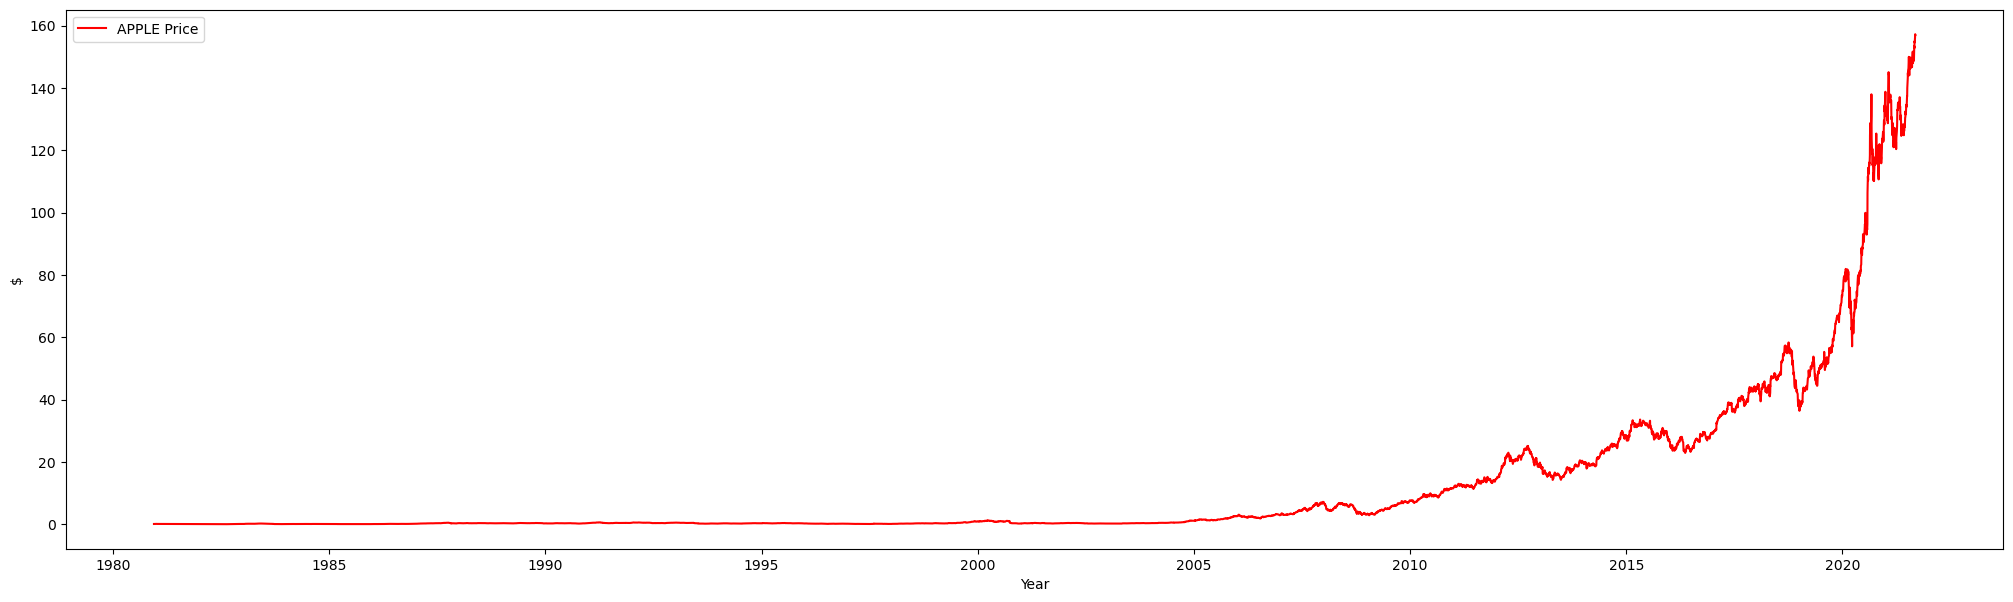

In [6]:
fig = plt.figure(figsize = (25, 7))
plt.plot(data.Date,data.High, color = 'red', label = 'APPLE Price')
plt.xlabel('Year')
plt.ylabel('$')
plt.legend()
plt.show()

# Splitting data into training and testing

In [7]:
data.shape
#rows, colums

(10272, 6)

In [8]:
# 80% will be used for traning, and 20% for testing

train_size = 0.8       # 80%
split_index = int(train_size * data.shape[0])

factors_column = ['Open', 'High', 'Low', 'Close', 'Volume']
y_col_index = 3 # Close

train_set = data[factors_column].values[:split_index]
test_set = data[factors_column].values[split_index:]

In [9]:
split_index

8217

# Scaling data between 0-1
for better learning

In [10]:
from sklearn.preprocessing import MinMaxScaler

# scale our price from 0 to 1

sc = MinMaxScaler(feature_range = (0, 1))
train_set_scaled = sc.fit_transform(train_set)
test_set_scaled = sc.fit_transform(test_set)

In [11]:
train_set_scaled[0]

array([0.00314274, 0.00315307, 0.00317783, 0.00316636, 0.0631981 ])

# Predicting Closing Price

## Generate windowed timestamp data

In [12]:
# this function will combine data of 60 days (we can change it using time_window parameter)
days_step = 1         # skip 7 days in between, can be set to 1 day
time_window = 60     # 8 weeks
def generate_data(series, y_col_index, time_window=60, days_step=1):
  X = []
  y = []
  for i in range(60, len(series)):
    X.append(series[i-time_window: i: days_step])
    y.append(series[i, y_col_index])
  return (np.array(X), np.array(y))

In [13]:
X_train, y_train = generate_data(train_set_scaled, y_col_index, time_window, days_step)
X_test, y_test = generate_data(test_set_scaled, y_col_index, time_window, days_step)

In [14]:
print('Training data shape (Input): ',X_train.shape)
print('Training data shape (Output): ',y_train.shape)
print('We will observe {} days price to predict next day price'.format(X_train.shape[1]))

Training data shape (Input):  (8157, 60, 5)
Training data shape (Output):  (8157,)
We will observe 60 days price to predict next day price


## Create Multi Layer LSTM Network

In [15]:
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout

In [18]:
model = Sequential()

# layer 1
model.add(LSTM(units = 50, return_sequences = True, input_shape = X_train.shape[1:]))
model.add(Dropout(0.2))

# layer 2
model.add(LSTM(units = 30, return_sequences = True))
model.add(Dropout(0.2))

# layer 3
model.add(LSTM(units = 10, return_sequences = True))
model.add(Dropout(0.2))

# layer 4
model.add(LSTM(units = 1))

/Users/shree/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 30)         │         9,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 10)         │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 1)              │            48 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,608 (88.31 KB)

 Trainable params: 22,608 (88.31 KB)

 Non-trainable params: 0 (0.00 B)

## Compile and train LSTM Network

In [20]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(X_train,
                    y_train,
                    epochs = 50,
                    batch_size = 64,
                    validation_data = (X_test, y_test))

Epoch 1/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0078 - val_loss: 0.0019
Epoch 2/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 6.0218e-04 - val_loss: 7.8476e-04
Epoch 3/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 5.0226e-04 - val_loss: 8.3689e-04
Epoch 4/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 4.3185e-04 - val_loss: 6.4896e-04
Epoch 5/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 4.5290e-04 - val_loss: 6.7497e-04
Epoch 6/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 3.0300e-04 - val_loss: 6.4377e-04
Epoch 7/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 3.1391e-04 - val_loss: 6.6716e-04
Epoch 8/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 3.0930e-04 - val_loss: 6.0491e-04
Epoch 9/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 2.6561e-04 - val_loss: 6.3013e-04
Epoch 10/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 2.7198e-04 - val_loss: 6.4274e-04
Epoch 11/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - l

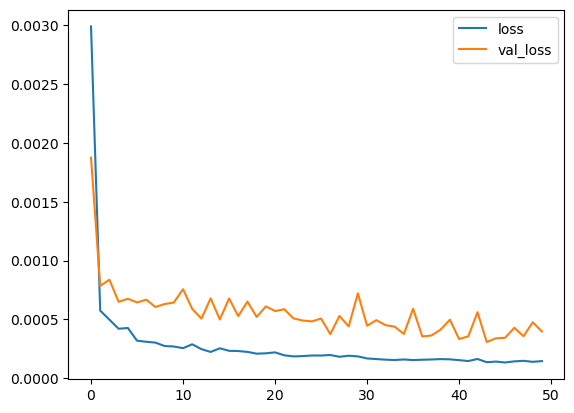

In [21]:
plt.plot(range(len(history.history['loss'])),history.history['loss'], label='loss')
plt.plot(range(len(history.history['val_loss'])),history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

## Test trained LSTM Network

In [22]:
test_prediction = model.predict(X_test)
test_prediction = (test_prediction * sc.data_range_[y_col_index]) + sc.data_min_[y_col_index]

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


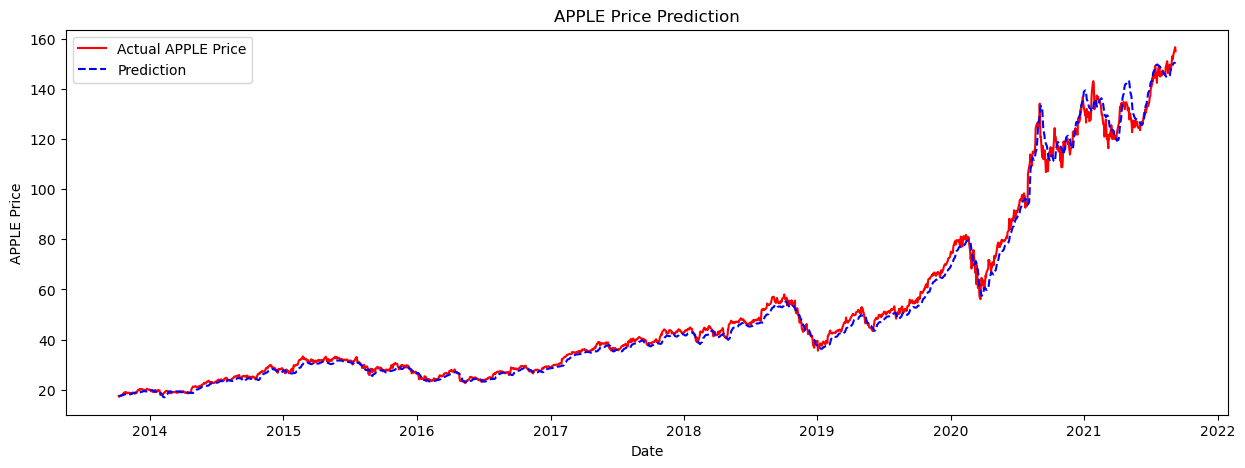

In [23]:
fig = plt.figure(figsize = (15, 5))
plt.plot(data.Date.values[ split_index+60 : ], data.Close.values[ split_index+60: ], 'r-', label = 'Actual APPLE Price')
plt.plot(data['Date'].values[split_index+60 : ], test_prediction, 'b--', label = 'Prediction')

plt.title('APPLE Price Prediction')
plt.xlabel('Date')
plt.ylabel('APPLE Price')
plt.legend()
plt.show()

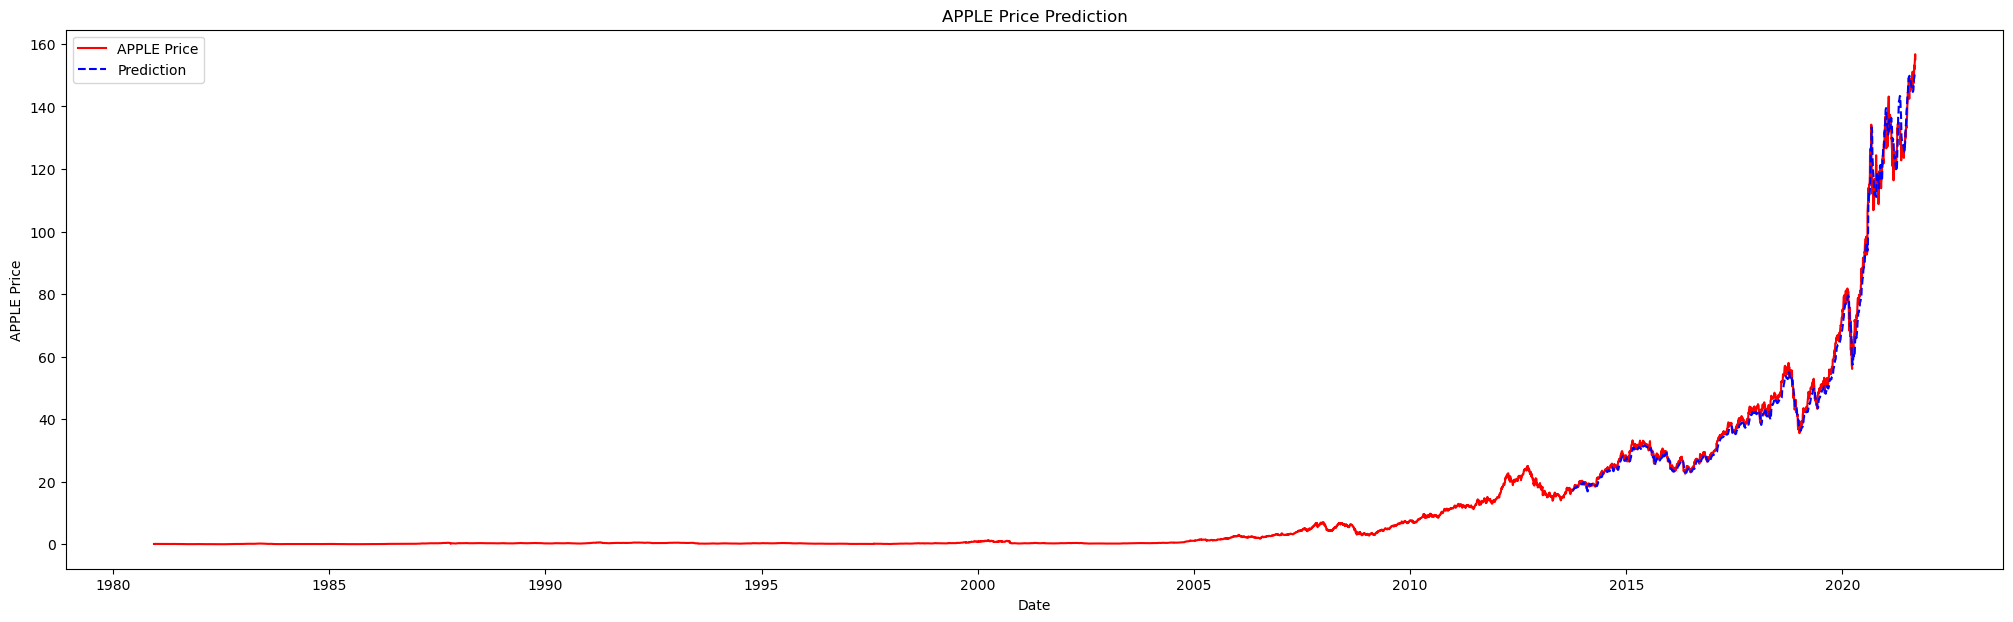

In [24]:
fig = plt.figure(figsize = (25, 7))
plt.plot(data.Date, data.Close, 'r-', label = 'APPLE Price')
plt.plot(data['Date'].values[split_index+60 : ], test_prediction, 'b--', label = 'Prediction')

plt.title('APPLE Price Prediction')
plt.xlabel('Date')
plt.ylabel('APPLE Price')
plt.legend()
plt.show()

# Predicting every parameter (Open, High, Low, Close, Volume)

## Gnerating windowed timestamp data

In [25]:
# this function will combine data of 60 days (we can change it using time_window parameter)
time_window = 7*4      # 4 weeks
days_step = 7         # skip 7 days in between, can be set to 1 day
def generate_data(series, time_window=60, days_step=1):
  X = []
  y = []
  for i in range(60, len(series)):
    X.append(series[i-time_window: i: days_step])
    y.append(series[i])                                 # <---- only changed this, insetead of taking only closing price, every column value is used
  return (np.array(X), np.array(y))

In [26]:
X_train, y_train = generate_data(train_set_scaled, time_window, days_step)
X_test, y_test = generate_data(test_set_scaled, time_window, days_step)

In [27]:
print('Training data shape (Input): ',X_train.shape)
print('Training data shape (Output): ',y_train.shape)
print('We will observe {} days price to predict next day price'.format(X_train.shape[1]))

Training data shape (Input):  (8157, 4, 5)
Training data shape (Output):  (8157, 5)
We will observe 4 days price to predict next day price


## Create Multi Layer LSTM Network

In [28]:
model = Sequential()

# layer 1
model.add(LSTM(units = 128, return_sequences = True, input_shape = X_train.shape[1:]))
model.add(Dropout(0.2))

# layer 2
model.add(LSTM(units = 64, return_sequences = True))
model.add(Dropout(0.2))

# layer 3
model.add(LSTM(units = 32, return_sequences = True))
model.add(Dropout(0.2))

# layer 4
model.add(LSTM(units = 16, return_sequences = True))
model.add(Dropout(0.2))

# layer 4
model.add(LSTM(units = 5))

In [29]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 4, 128)         │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 4, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 4, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 4, 16)          │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 5)              │           440 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,008 (523.47 KB)

 Trainable params: 134,008 (523.47 KB)

 Non-trainable params: 0 (0.00 B)

## Compile and train LSTM Network

In [30]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(X_train,
                    y_train,
                    epochs = 50,
                    batch_size = 64,
                    validation_data = (X_test, y_test))

Epoch 1/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0204 - val_loss: 0.0049
Epoch 2/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014 - val_loss: 0.0044
Epoch 3/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 4/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.9468e-04 - val_loss: 0.0029
Epoch 5/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.6944e-04 - val_loss: 0.0029
Epoch 6/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.9683e-04 - val_loss: 0.0028
Epoch 7/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.4103e-04 - val_loss: 0.0028
Epoch 8/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.2772e-04 - val_loss: 0.0037
Epoch 9/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.3534e-04 - val_loss: 0.0030
Epoch 10/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.1150e-04 - val_loss: 0.0026
Epoch 11/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.6083e-04 - val_loss: 0.0028
Epoch 12/50
128/128 

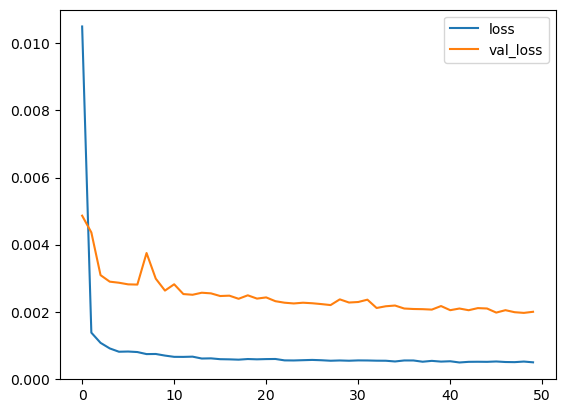

In [31]:
plt.plot(range(len(history.history['loss'])),history.history['loss'], label='loss')
plt.plot(range(len(history.history['val_loss'])),history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

## Test trained LSTM Network

In [32]:
test_prediction = model.predict(X_test)
test_prediction = sc.inverse_transform(test_prediction)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


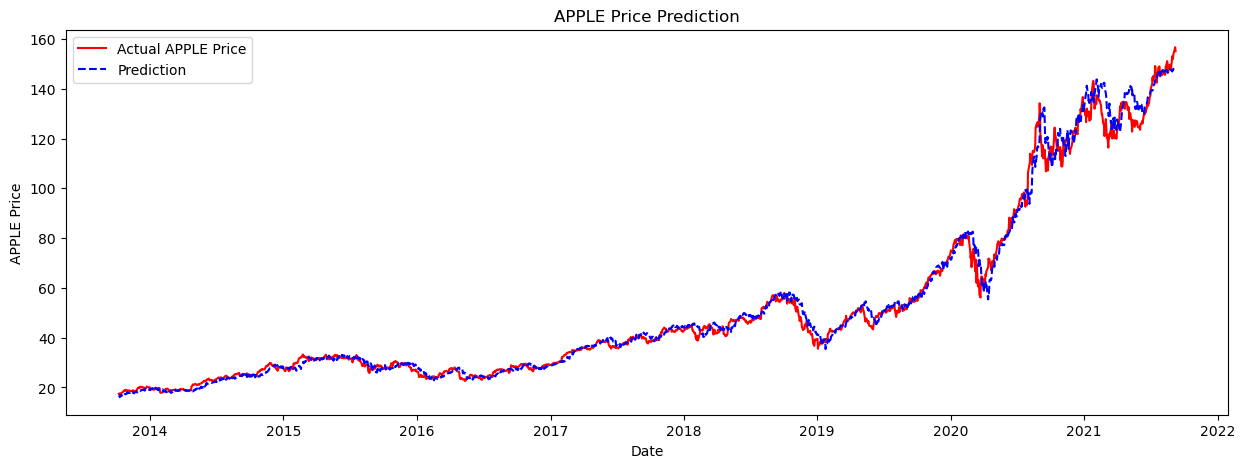

In [33]:
fig = plt.figure(figsize = (15, 5))
plt.plot(data.Date.values[ split_index+60 : ], data.Close.values[ split_index+60: ], 'r-', label = 'Actual APPLE Price')
plt.plot(data['Date'].values[split_index+60 : ], test_prediction[:,3], 'b--', label = 'Prediction')

plt.title('APPLE Price Prediction')
plt.xlabel('Date')
plt.ylabel('APPLE Price')
plt.legend()
plt.show()

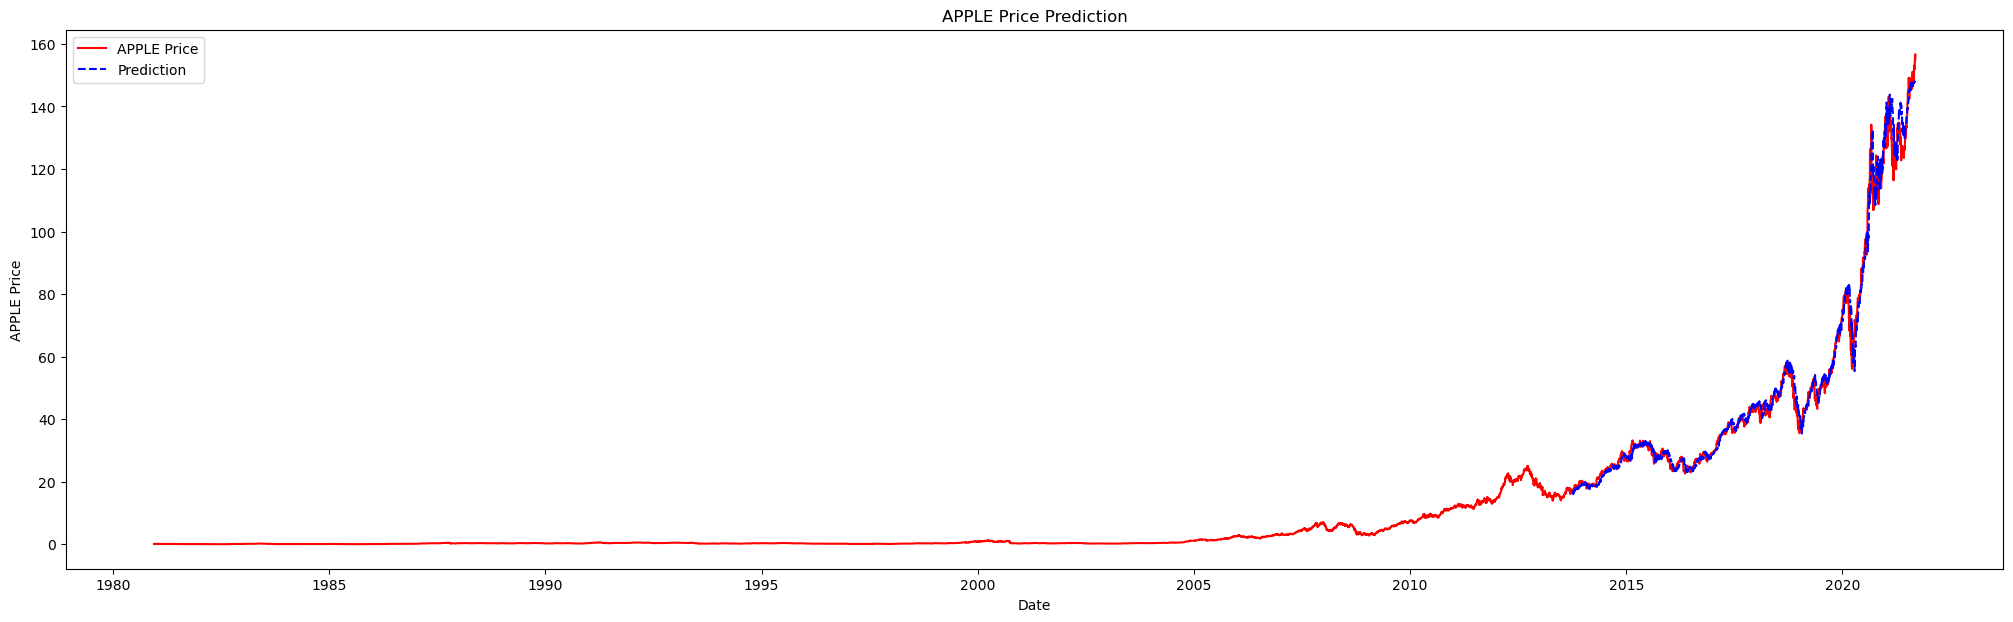

In [34]:
fig = plt.figure(figsize = (25, 7))
plt.plot(data.Date, data.Close, 'r-', label = 'APPLE Price')
plt.plot(data['Date'].values[split_index+60 : ], test_prediction[:,3], 'b--', label = 'Prediction')

plt.title('APPLE Price Prediction')
plt.xlabel('Date')
plt.ylabel('APPLE Price')
plt.legend()
plt.show()

In [35]:
def predict_n_days(df, n=30
                   , step=1):
    for i in range(n):
        X = df[factors_column].values[df.shape[0]-time_window::step]
        X = sc.transform(X)
        y = model.predict(np.expand_dims(X, axis=0))
        y = sc.inverse_transform(y)[0]

        next_day_prediction = { key: value for key, value in zip(factors_column, y)}
        next_day_prediction['Date'] = df.iloc[-1].Date + pd.Timedelta(days=1)

        df = df.append(next_day_prediction, ignore_index=True)
    return df

In [36]:
def predict_n_days(df, n=30, step=1):
    predictions = [] # List to store predictions before converting to dataframe
    for i in range(n):
        X = df[factors_column].values[df.shape[0]-time_window::step]
        X = sc.transform(X)
        y = model.predict(np.expand_dims(X, axis=0))
        y = sc.inverse_transform(y)[0]

        next_day_prediction = { key: value for key, value in zip(factors_column, y)}
        next_day_prediction['Date'] = df.iloc[-1].Date + pd.Timedelta(days=1)
        #Adding predictions to list instead of appending to the original dataframe
        predictions.append(next_day_prediction)

    # Converting predictions to a DataFrame and concatenating to the original
    predictions_df = pd.DataFrame(predictions)
    df = pd.concat([df, predictions_df], ignore_index=True)

    return df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1

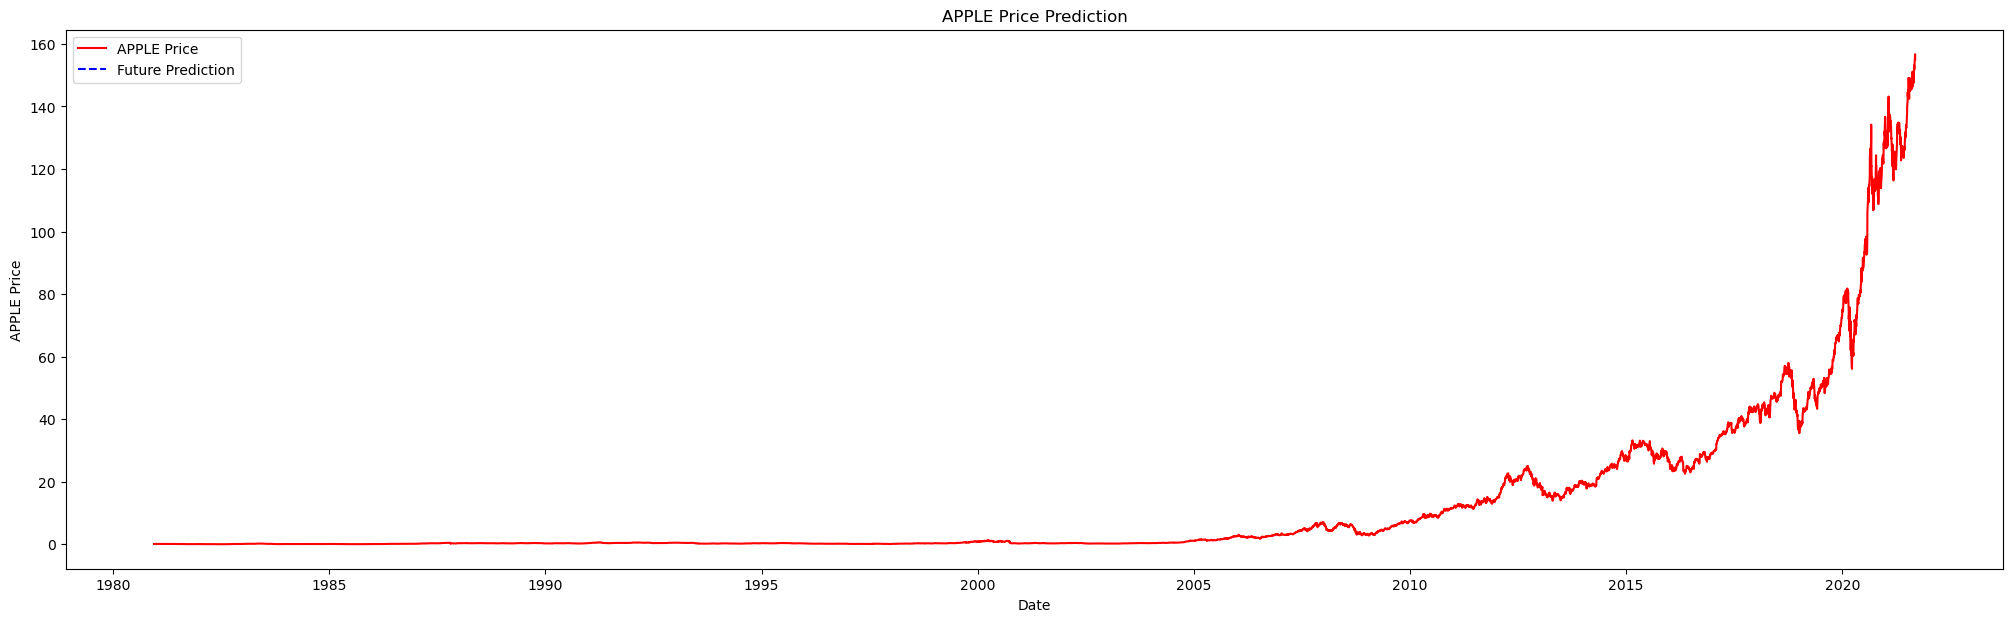

In [37]:
days= 30
predicted_df = predict_n_days(data,days,days_step) # This line executes the function, storing the result in 'predicted_df'
predictions_df = predicted_df # We are assigning the results of the function (in predicted_df) to predictions_df

fig = plt.figure(figsize = (25, 7))
plt.plot(data.Date, data.Close, 'r-', label = 'APPLE Price')
# We are now using the predictions_df variable containing the results from the previous cell
plt.plot(predictions_df.Date.values[-days: ], predictions_df.Close[-days:], 'b--', label = 'Future Prediction')

plt.title('APPLE Price Prediction')
plt.xlabel('Date')
plt.ylabel('APPLE Price')
plt.legend()
plt.show()